In [45]:
import numpy as np                                                             #Must normalize spectra (i.e. find median value across each spectrum, and then divide each spectrum by this value.)
from astropy.io import fits
import matplotlib.pyplot as py
%matplotlib inline

In [50]:
# begin to read in the fits file
hdu = fits.open('/Users/AnikaKamath/Desktop/Carbonstars/subMasterSPLASH.fits')

In [51]:
data = hdu[1].data

In [52]:
# THIS NEEDS TO BE FIRST
# decreasing data from SPLASH to only include our indicators: mask number, slitname, and objname
totalsplashstars = []
for i in range(data.size):
    splashstar = []
    splashstar += [data['MASK'][i]]
    splashstar += [int(data['SLITNAME'][i])]
    splashstar += [data['OBJNAME'][i]]
    totalsplashstars += [splashstar]

In [53]:
# THIS NEEDS TO BE SECOND
# decreasing range of submasterSPLASH to only masks that start with mct6 
mctmask = totalsplashstars[19748:]

In [54]:
#open text file and split each line into words aka strings
x = []
with open('/Users/AnikaKamath/Desktop/Carbonstars/CSTARS_FOR_KATIE.txt') as f:
    for line in f:
        L = line.split()
        x += [L] 

In [55]:
# cuts down to only extremely strong carbon stars; there are 5
extreme = x[3:8]
# cuts down to only strong carbon stars; there are 87
strong = x[15:102]
# cuts down to only medium carbon stars; there are 7
medium = x[109:116]
# cuts down to only weak carbon stars; there are 85 BUT THE FUNCTION SHOWS 84 because it counts a MWFG star not in SPLASH
weak = x[123:208]
# cuts down to only marginal carbon stars; there are 84
marginal = x[215:299]

In [56]:
# function that matches confirmed carbon stars on the list with stars in subMasterSPLASH
def identifysplash(array):
    for i in range(0, len(array)):
        array[i] = array[i][:4] #takes first 4 entries, disregard stars which indicate notes
        array[i].remove(array[i][2]) #disregard second entry which is slitname in specta program
        array[i][1] = int(array[i][1])# converts slit number to an integer so easily comparable to other slit
    splashid = []
    for k in range(0, len(array)): 
        test = array[k]
        for p in range(0, len(mctmask)): 
            if mctmask[p] == test:
                splashid.append(p + 19748) #the rows of all strong carbon stars
                #i add 19748 because 'mct6' masks start on row 19748 to the end
    #checking the output, which is a list of the rows in SPLASH with strong carbon stars features
    return(splashid)
    #checking the length of the list of rows with strong carbon star features (IT'S CORRECT YAY)

In [57]:
#assigning variables to the output lists of the functions; these lists contain the numbers of the rows with these stars
#'nice' stars have zquals of 1 or greater than 3
# all carbon stars are "nice" except for 1: 23092 in extreme; i noted this elsewhere
extremes = identifysplash(extreme)
nice_extremes = {p for p in extremes if data['ZQUAL'][p] >= 3 or data['ZQUAL'][p] == 1}
    #star clusters = none
    #automatically found serendips = none
    #manually found serendips = none
strongs = identifysplash(strong)
nice_strongs = {p for p in strongs if data['ZQUAL'][p] >= 3 or data['ZQUAL'][p] == 1}
#threshold for signal to noise ratio: 17
good_strongs = {p for p in strongs if data['ZSNR'][p] >= 17} & nice_strongs
good_strongs = list(good_strongs)

    #star clusters = none
    #automatically found serendips = 20558, 25041
    #manually found serendips = 20867
mediums = identifysplash(medium)
nice_mediums = {p for p in mediums if data['ZQUAL'][p] >= 3 or data['ZQUAL'][p] == 1}
    #star clusters = none
    #automatically found serendips = none
    #manually found serendips = none
weaks = identifysplash(weak)
nice_weaks = {p for p in weaks if data['ZQUAL'][p] >= 3 or data['ZQUAL'][p] == 1}
#threshold for signal to noise ratio: 35
good_weaks = {p for p in weaks if data['ZSNR'][p] >= 35} & nice_weaks
good_weaks = list(good_weaks)
    #star clusters = 22618, 23624, 23859
    #automatically found serendips = none
    #manually found serendips = 20390, 20867
marginals = identifysplash(marginal)
nice_marginals = {p for p in marginals if data['ZQUAL'][p] >= 3 or data['ZQUAL'][p] == 1}
#threshold for signal to noise ratio: 16
good_marginals = {p for p in marginals if data['ZSNR'][p] >= 16} & nice_marginals
good_marginals = list(good_marginals)
    #star clusters = 20463, 23365, 23368, 23377, 23389, 23390, 23392
    #automatically found serendips = 21031, 21813, 22159, 23627
    #manually found serendips = none

In [58]:
total = list(range(0,data.size))
carbonstars = extremes + strongs + mediums + weaks + marginals
others = {x for x in total if x not in carbonstars}
others = list(others)

In [59]:
def plotcoad(spec_array, clr, ymax, ymin = -100, xmin = 5000, xmax = 10000):
    py.rcParams['figure.figsize'] = 40, 15
    py.xlabel('wavelength (angstroms)')
    py.plot(data['LBIN'][1], spec_array, color = clr)
    py.xlim(xmin, xmax)
    py.ylim(ymin, ymax)    
    # graph that shit 

In [60]:
#array normalize
lowerThreshArray = 6924
upperThreshArray = 7695
def normalize(array):  # 6924 and 7695 are indices of the spectral array that correspond to 8500 and 9000 respectively..
    norSpecArray = []
    norVarArray = []
    for k in array:
        specData = data['SPEC'][k]
        varData = data['IVAR'][k]
        centralSpec = specData[lowerThreshArray:upperThreshArray+1][~np.isnan(specData[lowerThreshArray:upperThreshArray+1])]
        nor = 1 / np.median(centralSpec)
        normalSpec = nor*specData
        ivarNormalize = (1/nor)**2
        norVar = ivarNormalize*varData
        norSpecArray.append(normalSpec)
        norVarArray.append(norVar)
    norSpecArray =  np.asarray(norSpecArray)
    norVarArray =  np.asarray(norVarArray)
    return [norSpecArray, norVarArray]

In [61]:
normalizedStrongs = normalize(strongs)
normalizedWeaks = normalize(weaks)
normalizedMarginals = normalize(marginals)


/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply
/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [62]:
def getCoaddSpec2(normArray):
    coaddivar = np.nansum(normArray[1], axis = 0)
    coaddspec = np.nansum(normArray[0]*normArray[1], axis=0)
    try:
        coaddspec = coaddspec/coaddivar
    except:
        coaddspec = coaddspec
    return coaddspec

In [63]:
strongCoaddSpec = getCoaddSpec2(normalizedStrongs)

/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


In [64]:
weakCoaddSpec = getCoaddSpec2(normalizedWeaks)

/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


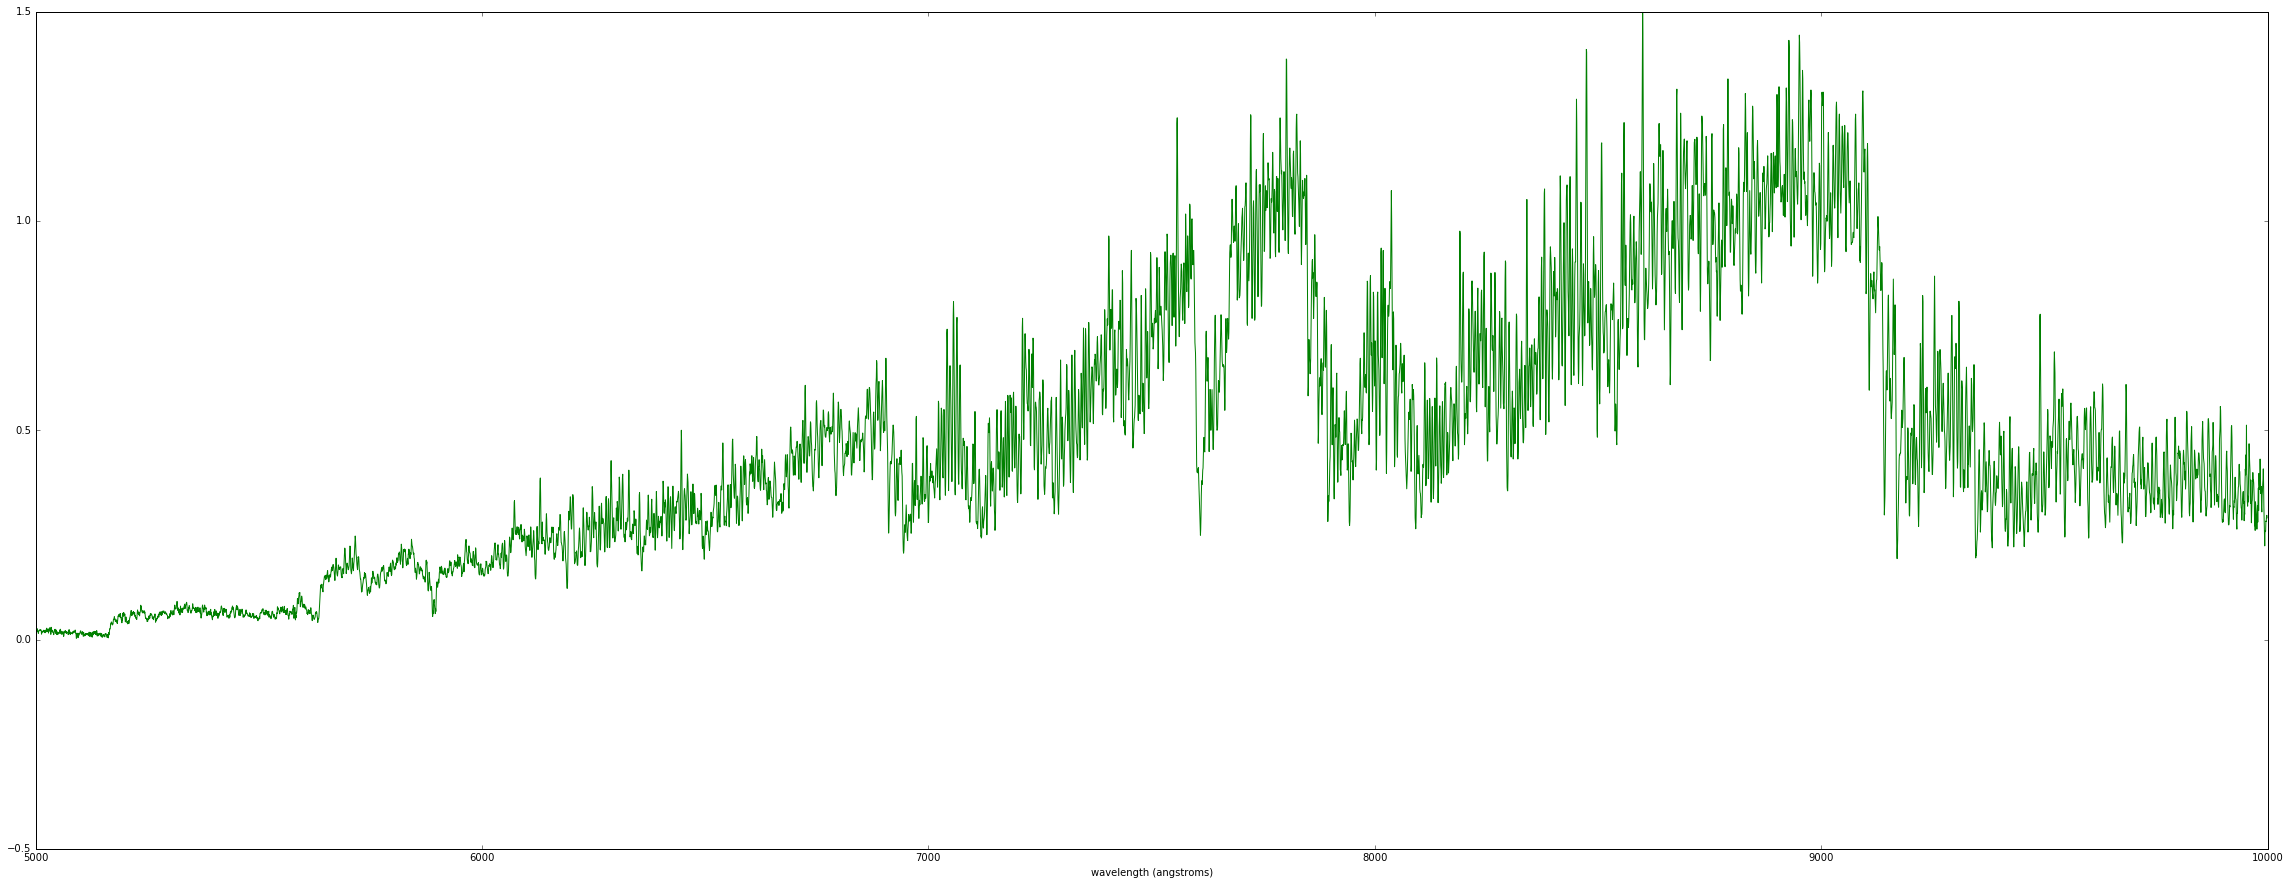

In [65]:
plotcoad(strongCoaddSpec, 'g', 1.5, -0.5)

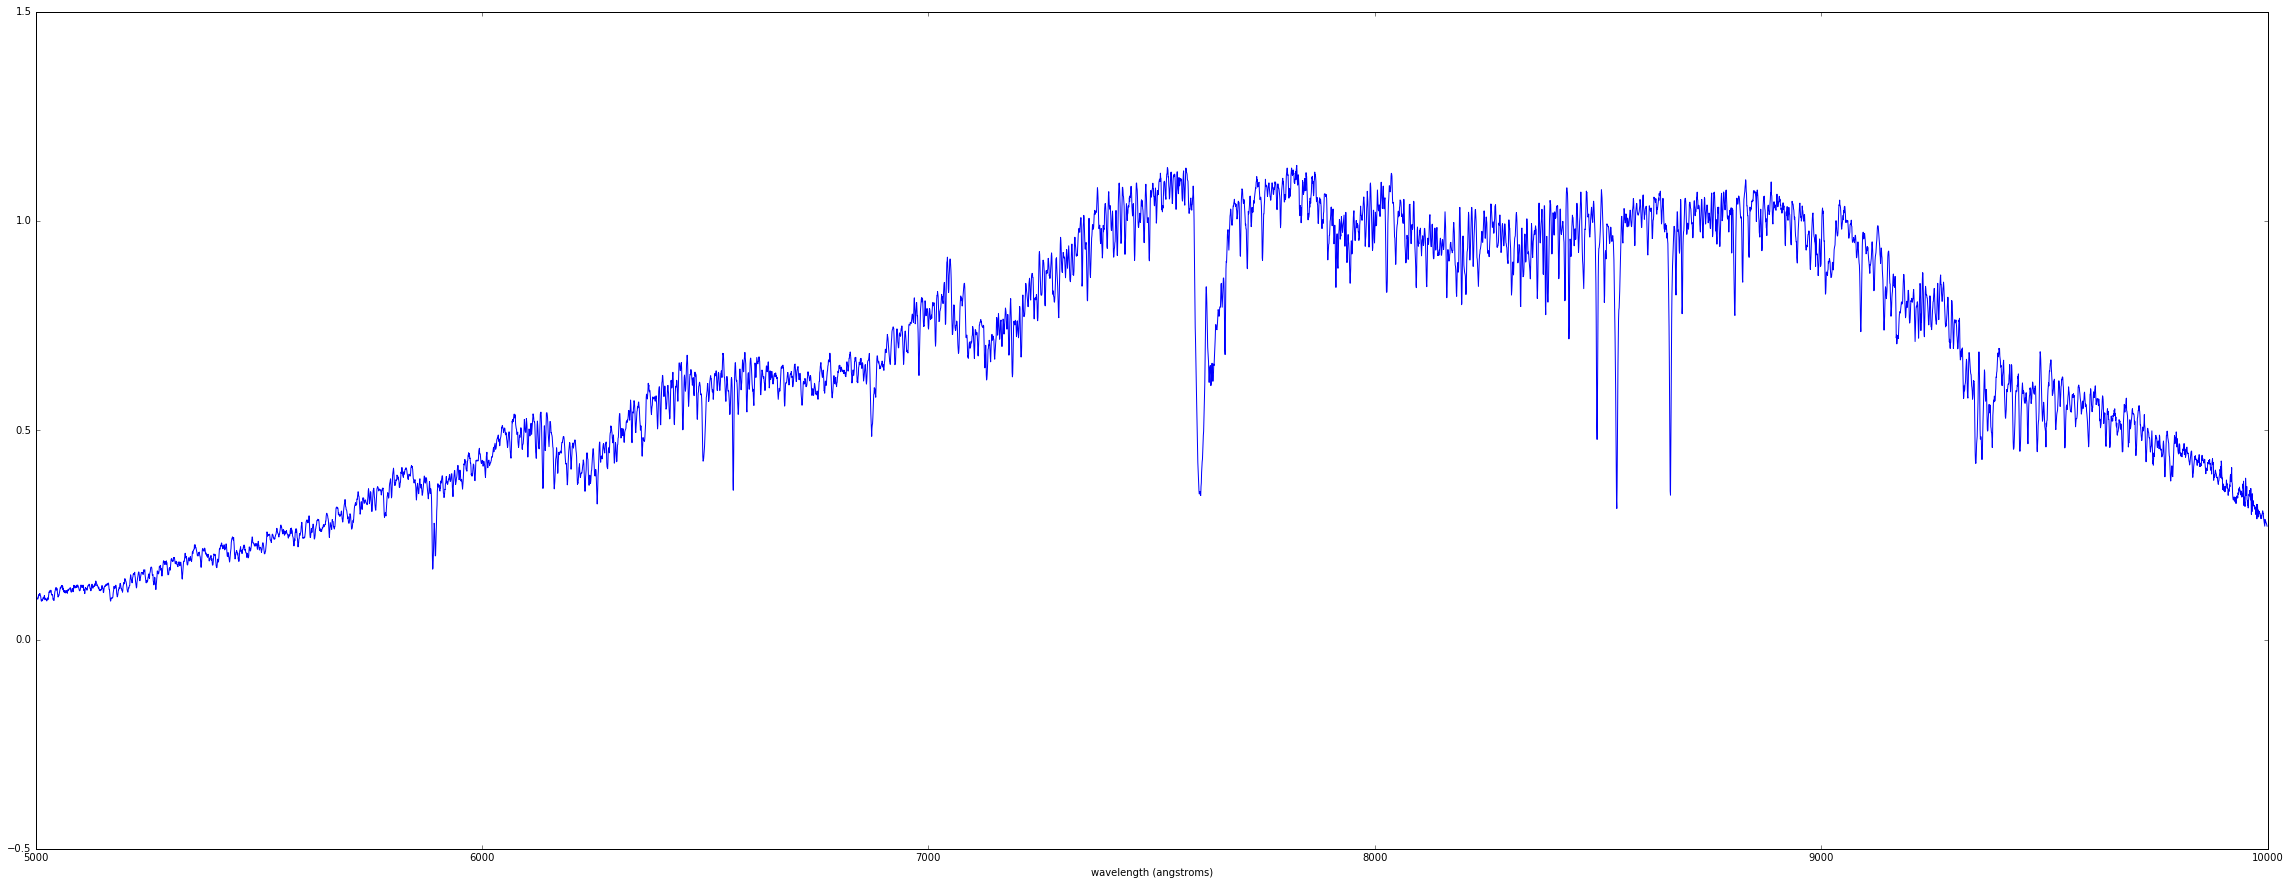

In [66]:
plotcoad(weakCoaddSpec, 'b', 1.5, -0.5)

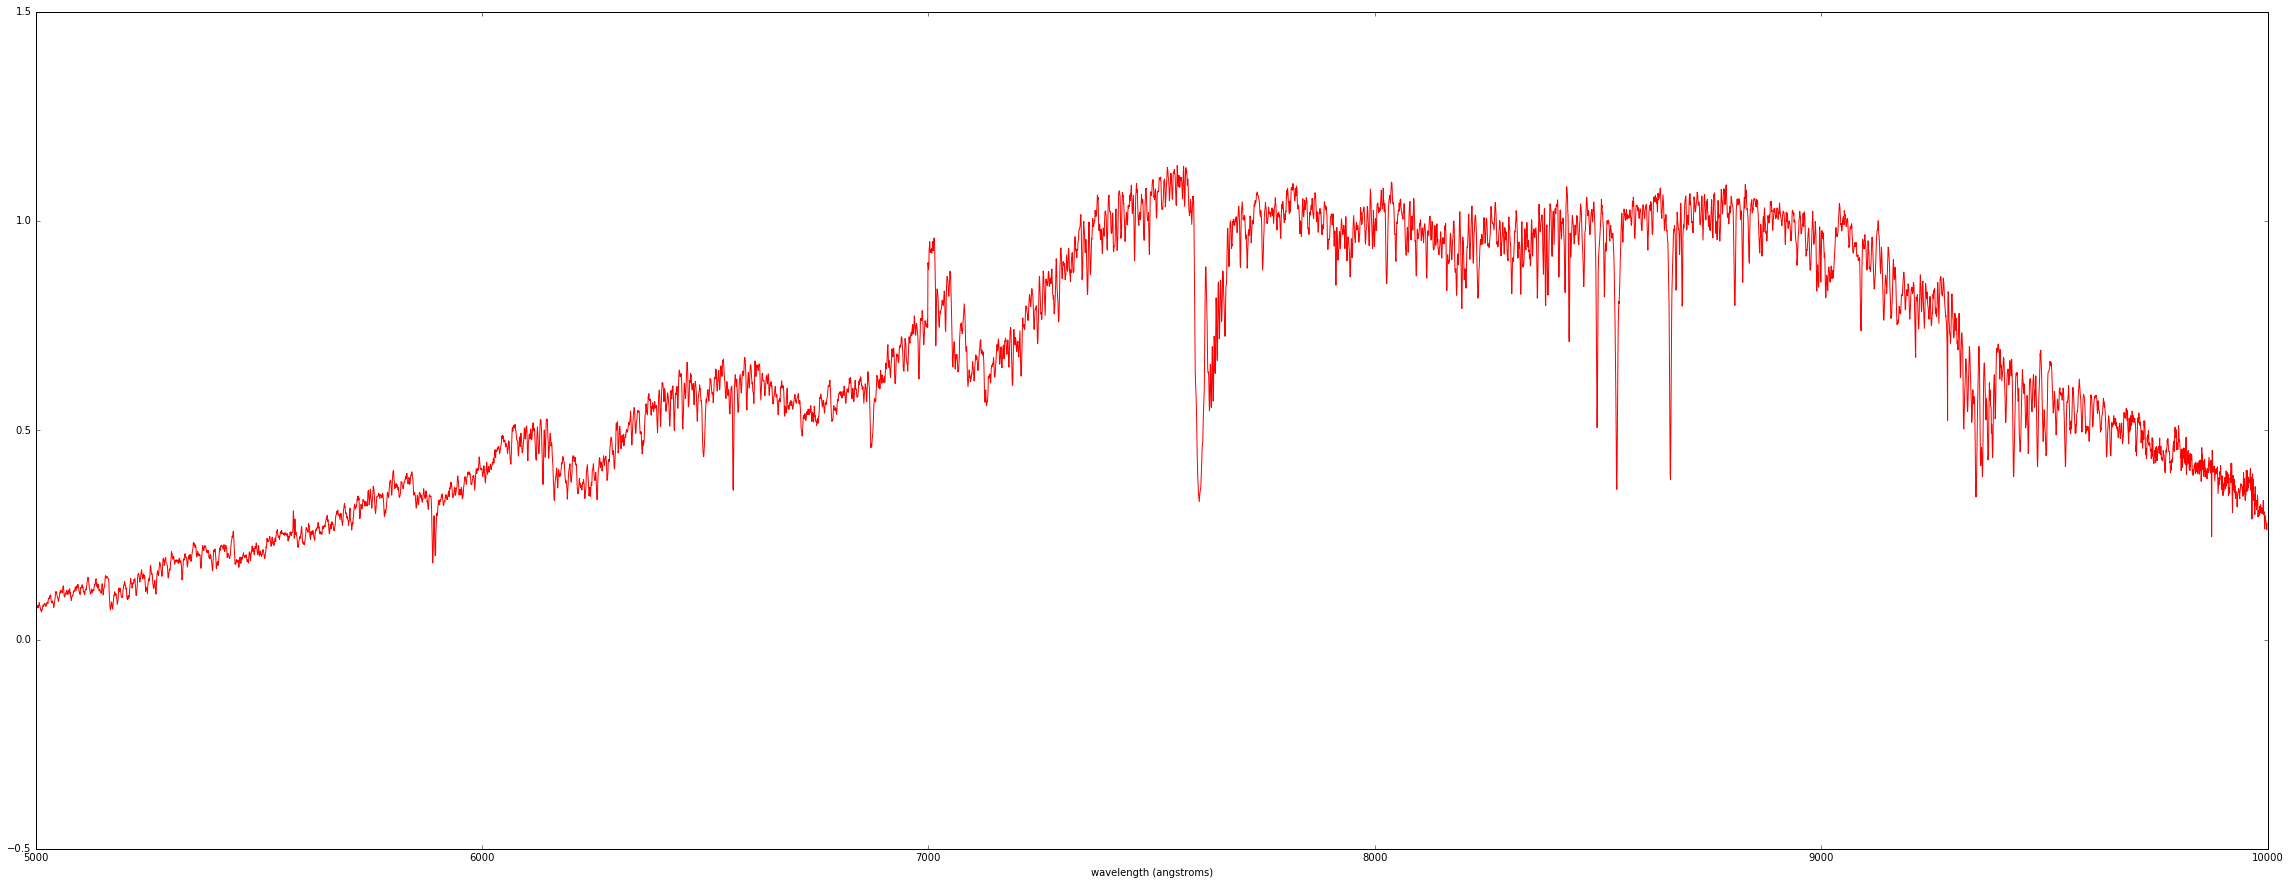

In [67]:
plotcoad(marginalCoaddSpec, 'r', 1.5, -0.5)

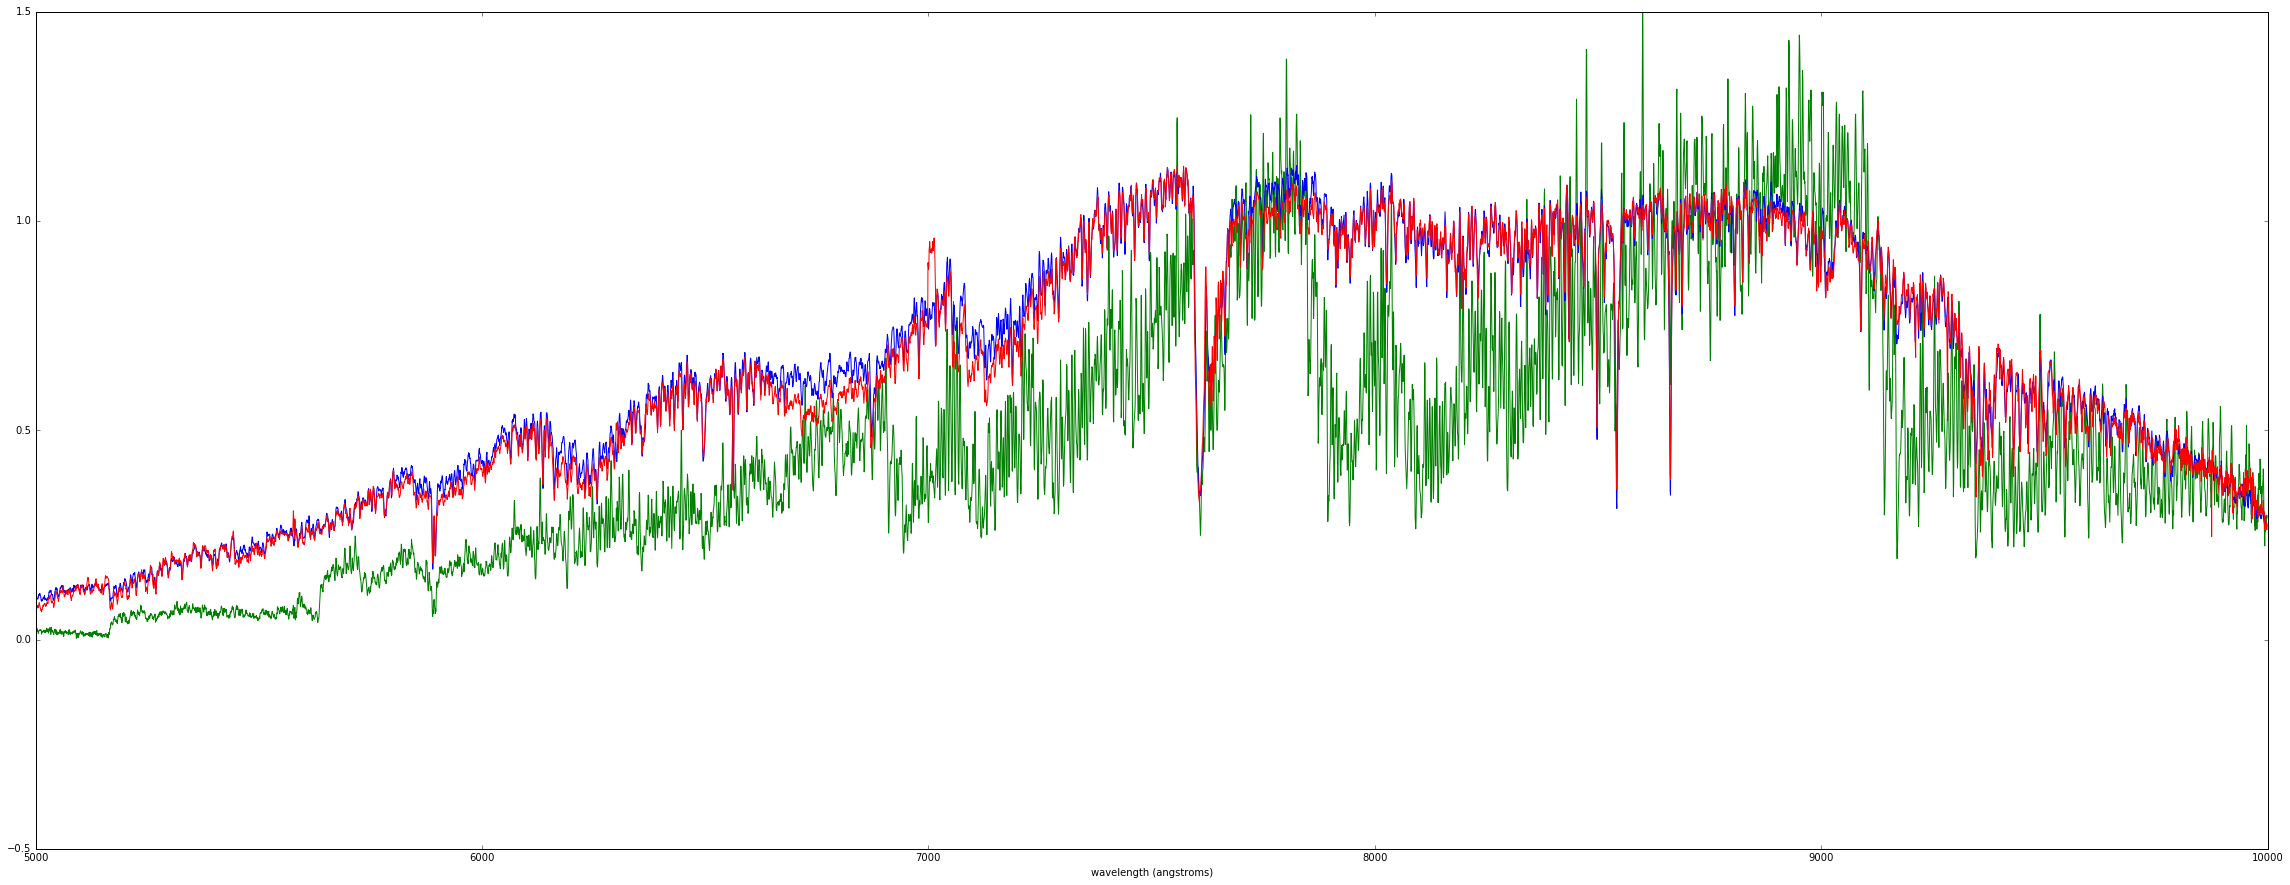

In [68]:
plotcoad(strongCoaddSpec, 'g', 1.5, -0.5)
plotcoad(weakCoaddSpec, 'b', 1.5, -0.5)
plotcoad(marginalCoaddSpec, 'r', 1.5, -0.5)

In [70]:
# we compare only within a certain threshold because tends to be noise on on far left and right
def normalizeSpec(starSpec, lowerThresh=4000, upperThresh=8000):
    starSpec = starSpec[lowerThresh:upperThresh+1]
    #we don't want the starSpec to have no nan values because they act as placeholders
    #assign a different variable  to the spectra without nan
    diffSpec = starSpec[~np.isnan(starSpec)] 
    nor = 1 / np.median(diffSpec)
    return nor*starSpec 

In [116]:
tempSpec = weakCoaddSpec[4000:8001]
#py.plot(data['LBIN'][1][4000:8001], tempSpec, color = 'b')

def getMatchScore(testStar):
    testSpec = normalizeSpec(data['SPEC'][testStar])
    sq_subt = np.square(np.subtract(testSpec, tempSpec))
    div = len(data['SPEC'][carbon_tests[numTestStar]][~np.isnan(data['SPEC'][carbon_tests[numTestStar]])])
    total = np.nansum(sq_subt)/div
    total = np.sqrt(total)
    total = total*100
    return [testSpec, total]

def compareScore(array):
    testSpecArray = []
    starScores ={}
    for numTestStar in range(len(array)):
        spec_score_array = getMatchScore(array[numTestStar])
        testSpecArray.append(spec_score_array[0])
        starScores[array[numTestStar]] = spec_score_array[1]
    #following line sorts keys based on their values and assigns to list called sortedDict
    #lower values (scores) are at the first part of the array
    sortedDict = sorted(starScores, key=lambda key: starScores[key])
    print()
    print("star ","|", "  score")
    print("--------------------")
    for i in sortedDict:
        print(i, "|", starScores[i])
    return [testSpecArray, starScores, sortedDict]

In [ ]:

def getMatchScore(testStar):
    testSpec = normalizeSpec(data['SPEC'][testStar])
    sq_subt = np.square(np.subtract(testSpec, tempSpec))
    div = len(data['SPEC'][carbon_tests[numTestStar]][~np.isnan(data['SPEC'][carbon_tests[numTestStar]])])
    total = np.nansum(sq_subt)/div
    total = np.sqrt(total)
    total = total*100
    return testSpec, total

def compareScore(array):
    testSpecArray = []
    starScores ={}
    for numTestStar in range(len(array)):
        testStarSpec, score = getMatchScore(array[numTestStar])
        testSpecArray.append(testStarSpec)
        starScores[array[numTestStar]] = score
    #following line sorts keys based on their values and assigns to list called sortedDict
    #lower values (scores) are at the first part of the array
    sortedDict = sorted(starScores, key=lambda key: starScores[key])
    print()
    print("star ","|", "  score")
    print("--------------------")
    for i in sortedDict:
        print(i, "|", starScores[i])
    return testSpecArray, starScores, sortedDict

In [69]:
# somewhat arbitrarily chosen list of 44 stars to test against the weak coaddition
# some from known marginal, strong, and weak populations
# others (23 of them) from noncarbon stars
carbon_tests = [33, 15952, 13585, 12226, 7276, 18011, 17921, 3316, 2918, 4211, 15586, 14788, 11920, 536, 19637, 16233, 15702, 17290, 9737, 3264, 3762, 12304, 20308, 24085, 24498, 24730, 21469, 2217, 23624, 22569, 23596, 21069, 23693, 24045, 21305, 21308, 21821, 21859, 24483, 20379, 20903, 24395, 20811, 23439]
carbon_tests.sort()

In [71]:
print("Index to Carbon Test list")
for testStar in range(len(carbon_tests)):
    print(testStar, carbon_tests[testStar])

Index to Carbon Test list
0 33
1 536
2 2217
3 2918
4 3264
5 3316
6 3762
7 4211
8 7276
9 9737
10 11920
11 12226
12 12304
13 13585
14 14788
15 15586
16 15702
17 15952
18 16233
19 17290
20 17921
21 18011
22 19637
23 20308
24 20379
25 20811
26 20903
27 21069
28 21305
29 21308
30 21469
31 21821
32 21859
33 22569
34 23439
35 23596
36 23624
37 23693
38 24045
39 24085
40 24395
41 24483
42 24498
43 24730


In [133]:
rand1Specs, rand1Scores, rand1SortedKeys = compareScore(carbon_tests)


star  |   score
--------------------
21821 | 5.12944060205
24045 | 7.22655533802
22569 | 7.24092571931
20903 | 7.5054231543
23693 | 7.71771525154
23596 | 8.02843877423
23439 | 8.63682786965
21859 | 8.93206241266
20379 | 9.5999697199
21069 | 10.8605167432
20811 | 12.3022310115
15702 | 14.5390906479
24483 | 14.8836584997
23624 | 15.9264486302
19637 | 16.3879997945
14788 | 20.2511639076
16233 | 21.5054929418
4211 | 21.7006609169
2918 | 23.8026824268
3264 | 25.1001073283
21305 | 25.6862096015
24085 | 26.3519274293
24498 | 26.9970758186
24395 | 27.157785452
21308 | 28.0418529478
11920 | 29.2664763873
24730 | 30.5908319103
18011 | 30.6012006598
15952 | 33.818513931
21469 | 34.0582007518
33 | 34.4938772777
12226 | 35.9885771869
17290 | 36.8951526154
20308 | 37.2547821088
17921 | 37.3690709712
15586 | 45.4076774457
3762 | 46.1782231319
536 | 47.2312472476
7276 | 55.5814269797
12304 | 74.4553248296
13585 | 84.861119552
2217 | 114.788220058
3316 | 378.237935043
9737 | 578.428914148


In [132]:
total = list(range(data.size))
mct6Specs, mct6Scores, mct6SortedKeys = compareScore(total[19748:])
#note the 0.0 value for star 22283 
#this is because there are NO VALUES in the spectra of star 22283

/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply
/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/AnikaKamath/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)



star  |   score
--------------------
22283 | 0.0
21821 | 5.12944060205
22009 | 5.15135915128
22019 | 5.24868786428
24233 | 5.53208701672
21729 | 5.89436256168
20291 | 6.00396680788
21565 | 6.85659090069
21588 | 6.94020289657
24045 | 7.22655533802
22569 | 7.24092571931
22099 | 7.24644951766
21858 | 7.27613578982
22549 | 7.46009068979
20903 | 7.5054231543
20267 | 7.54629242178
24912 | 7.55126387001
23312 | 7.61288168277
21918 | 7.68703188316
23693 | 7.71771525154
20290 | 7.76722313239
24339 | 7.7856707055
20312 | 7.82378686032
19842 | 7.84028810096
21495 | 7.87362725889
21945 | 7.90518486066
24404 | 7.94484157538
24490 | 7.97486619649
21500 | 8.01545118255
23596 | 8.02843877423
20320 | 8.08958499831
21474 | 8.15190011887
24898 | 8.15398353566
22579 | 8.23649013579
21508 | 8.38880066205
21489 | 8.44245654318
21174 | 8.55712787682
19856 | 8.57961200368
21555 | 8.5819947951
20313 | 8.6012542865
24539 | 8.60697341894
20310 | 8.6127265265
21338 | 8.63204850281
23439 | 8.63682786965
21323 | 8

In [134]:
# Displays the sorted ranking of star rows based on their scores in whatever array 
carbonRank = {}
for i in weaks:
    for k in range(len(mct6SortedKeys)):
        if i == mct6SortedKeys[k]:
            carbonRank[i] = k
sortedRank = sorted(carbonRank, key=lambda key: carbonRank[key])
print()
for i in sortedRank:
    print(i, "|", carbonRank[i])


21821 | 1
22009 | 2
22019 | 3
24233 | 4
21729 | 5
20291 | 6
21588 | 8
24045 | 9
22569 | 10
22099 | 11
21858 | 12
22549 | 13
23312 | 17
23693 | 19
20290 | 20
24339 | 21
20312 | 22
19842 | 23
23596 | 29
20320 | 30
21474 | 31
24898 | 32
22579 | 33
21508 | 34
21489 | 35
21174 | 36
20310 | 41
21338 | 42
21323 | 44
24051 | 45
20103 | 56
21523 | 59
24122 | 75
22847 | 84
19846 | 86
23663 | 88
21879 | 89
21466 | 94
24744 | 98
21069 | 103
22054 | 104
21878 | 112
22935 | 116
19943 | 132
23261 | 133
23529 | 142
21600 | 150
24696 | 161
21188 | 163
20268 | 166
21677 | 170
22020 | 181
24035 | 207
22855 | 285
24896 | 337
20867 | 390
24740 | 403
23624 | 431
21264 | 434
22982 | 460
22601 | 474
22561 | 510
24100 | 527
21255 | 545
22618 | 682
21350 | 817
23566 | 841
24742 | 848
23953 | 910
22602 | 971
23859 | 1018
20390 | 1354
20330 | 1359
22603 | 1555
23279 | 1667
19798 | 1675
21305 | 1710
21308 | 2006
21719 | 2483
22117 | 2497
22947 | 2571
21303 | 2605
22199 | 2618
20502 | 3261


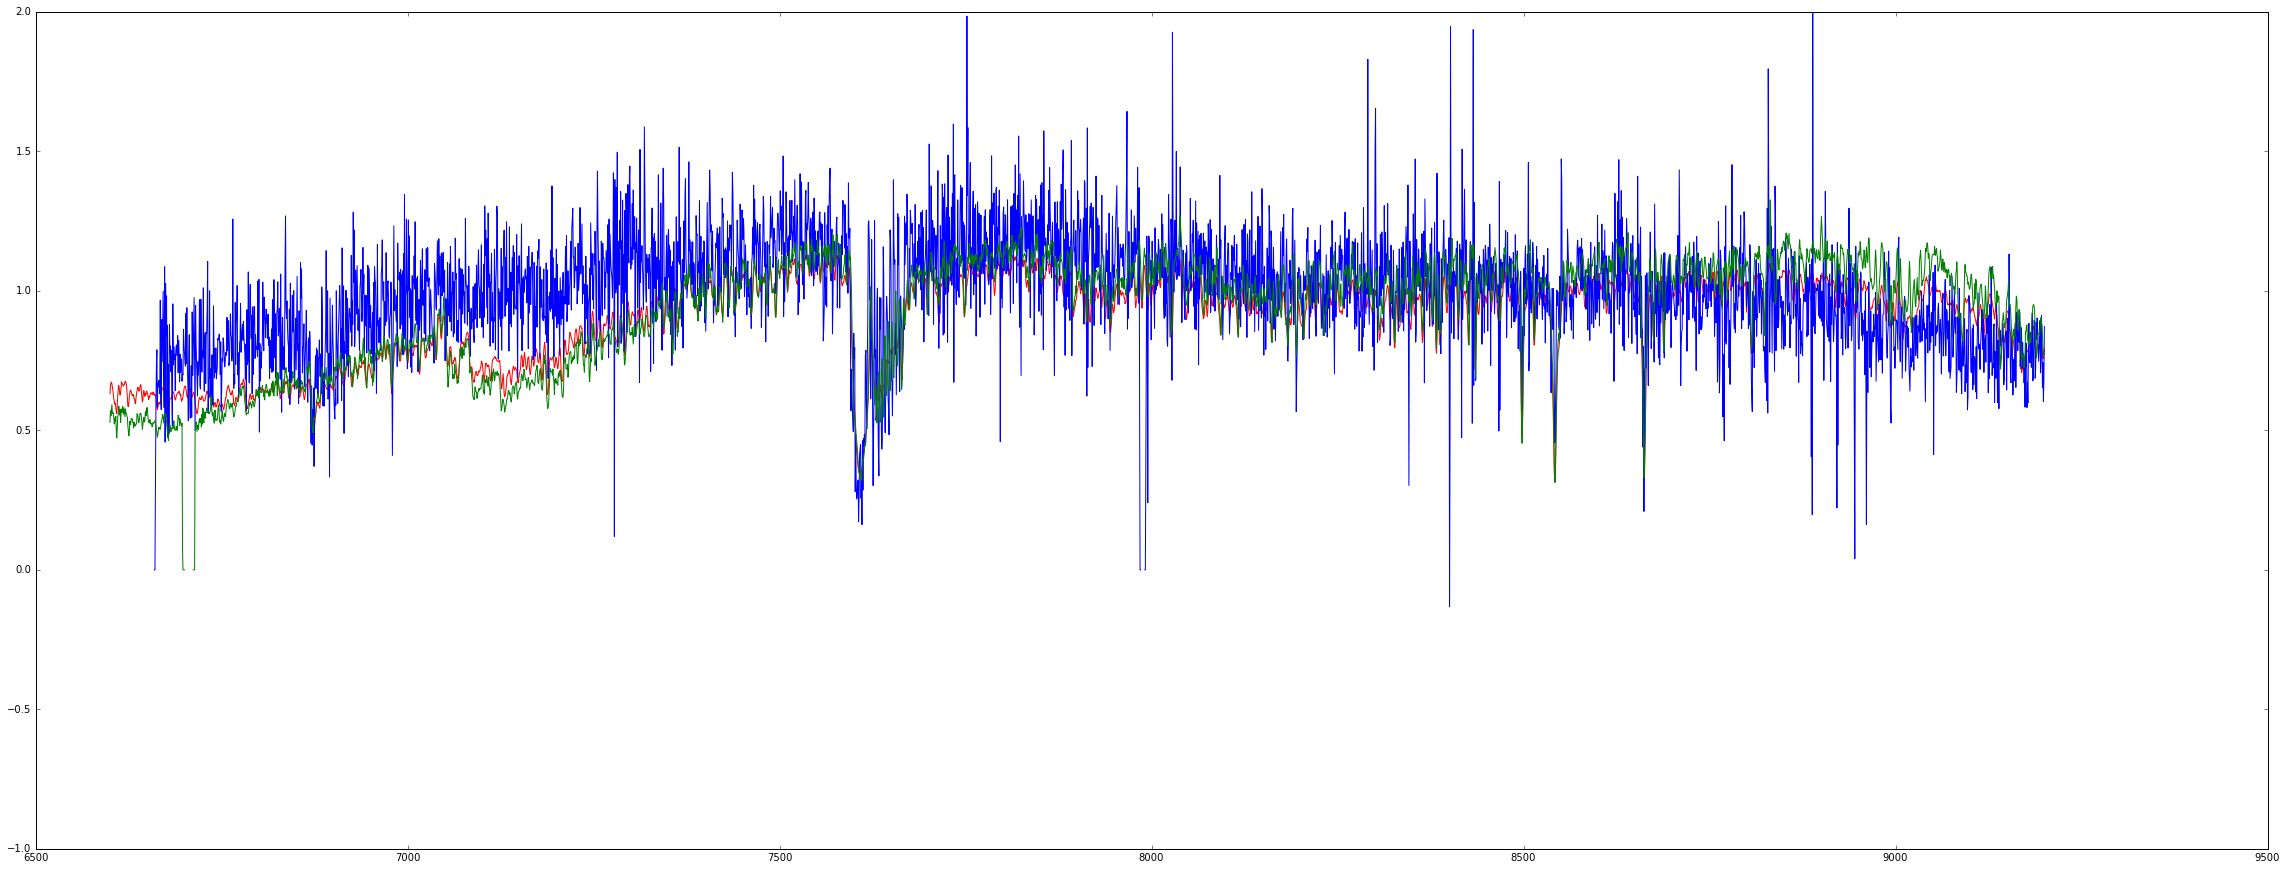

In [135]:
py.xlim(6500, 9500)
py.ylim(-1, 2)
py.plot(data['LBIN'][1][4000:8001], tempSpec, color = 'r')
py.plot(data['LBIN'][1][4000:8001], rand1Specs[16], color = 'b')
py.plot(data['LBIN'][1][4000:8001], rand1Specs[31], color = 'g')
#py.plot(data['LBIN'][1][4000:8001], rand1Specs[9], color = 'purple')
#py.plot(data['LBIN'][1][4000:8001], rand1Specs[0], color = 'darkorange')